In [16]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from operator import itemgetter, attrgetter
from datetime import date
from queue import PriorityQueue


In [118]:
# Constants

NOT_VISITED = -1
UNBLOCKED = 0
BLOCKED = 1
START = 2
END = 3
KNOWN_UNBLOCKED = 4
KNOWN_BLOCKED = 5
KNOWN_DEADEND = 6

COLORMAP = {
    NOT_VISITED : np.array([127,127,127]),
    UNBLOCKED : np.array([255,255,255]),
    BLOCKED : np.array([0,0,0]),
    START : np.array([255,0,0]),
    END : np.array([0,127,255]),
    KNOWN_UNBLOCKED : np.array([248,131,121]),
    KNOWN_BLOCKED : np.array([0,255,0]),
    KNOWN_DEADEND : np.array([0,255,255])
}

TEST_WORLDS = 5
TEST_WORLD_SIZE = 10

OUTPUT_BASE_PATH = "Outputs/"
TODAY = date.today()

In [119]:
class MinHeap:
    def __init__(self):
        self.elements = []
        self.size = 0
    def heapifyUpwards(self, i):
        while i != 0:
            p = (i - 1) // 2
            if self.elements[i][0] < self.elements[p][0]:
                self.elements[i], self.elements[p] = self.elements[p], self.elements[i]
            i = p

    def heapifyDownwards(self, i):
        while i < self.size:
            if 2 * (i + 1) >= self.size:
                m = (2 * i) + 1
            else:
                m = (2 * i) + 1 if self.elements[(2 * i) + 1][0] < self.elements[2 * (i + 1)][0] else 2 * (i + 1)
            if m>=self.size:
                break
            if self.elements[m][0] < self.elements[i][0]:
                self.elements[i], self.elements[m] = self.elements[m], self.elements[i]
            i = m
    def length(self):
        count=0
        i=0
        while i < self.size:
            count = count+1
            i = i+1
        return count
    def insert(self, k):
        self.elements.append(k)
        self.size+=1
        self.heapifyUpwards(self.size-1)

    def peek(self):
        print(self.elements)
        return self.elements[0]

    def pop(self):
        k = self.elements[0]
        self.elements[0] = self.elements[-1]
        del self.elements[-1]
        self.size-=1
        self.heapifyDownwards(0)
        return k

m = MinHeap()
m.insert((1,'a'))
m.insert((2,'c'))
m.insert((1,'e'))
m.insert((3,'a'))
print(m.peek())
m.pop()
print(m.peek())
m.insert((-1,'a'))
print(m.length())
print(m.peek())
print(m.pop())
print(m.pop())
print(m.pop())
print(m.pop())


[(1, 'a'), (2, 'c'), (1, 'e'), (3, 'a')]
(1, 'a')
[(1, 'e'), (2, 'c'), (3, 'a')]
(1, 'e')
4
[(-1, 'a'), (1, 'e'), (3, 'a'), (2, 'c')]
(-1, 'a')
(-1, 'a')
(1, 'e')
(2, 'c')
(3, 'a')


In [120]:
def calculateAllNeighbours(location, t_size):
    # We first calculate all 9 cells in the neighbourhood,
    # and then filter out itself and the ones in the cross
    # by filtering elements with manhattan distance not equal to one.
    return list(filter(lambda x: abs(location[0]-x[0])+abs(location[1]-x[1])==1, [(x,y) for x in range(location[0]-1 if location[0]-1 > -1 else 0, location[0]+2 if location[0]+1<t_size else t_size) for y in range(location[1]-1 if location[1]-1 > -1 else 0, location[1]+2 if location[1]+1<t_size else t_size)]))

In [121]:
def getRandomCoordinates(t_size):
    # Returns a tuple of coordinnates
    return (random.randint(0, t_size - 1), random.randint(0, t_size-1))

def getRandomCoordinatesInQuarter(t_size, quarter):
    # Returns a tuple of coordinnates
    t = t_size - 1
    x = (0,int(t/4)) if quarter[0]==0 else (int(3*t/4), t)
    y = (0,int(t/4)) if quarter[1]==0 else (int(3*t/4), t)
    return (random.randint(x[0], x[1]), random.randint(y[0], y[1]))

In [122]:
def generateEnvironment(t_size):
    # Initially all cells are set as not visited
    # 1 marks blocked, 0 marks unblocked, -1 for not visited
    grid = np.full(shape = (t_size, t_size), fill_value = NOT_VISITED, dtype = np.int8)

    # A random location on the grid to begin with, and mark it visited
    begin = getRandomCoordinates(t_size)
    grid[begin[0], begin[1]] = BLOCKED

    # Using a stack as a frontier, so we can use DFS to generate the blocked paths
    frontier = []
    frontier.append(begin)
    while(len(frontier) > 0):
        current = frontier.pop()
        # Calculating the current's neighbours
        neighbours = calculateAllNeighbours(current, t_size)
        for nx,ny in neighbours:
            if grid[nx,ny] == NOT_VISITED:
                # If the location is not visited, add it to the frontier
                frontier.append((nx,ny))
                # Mark it blocked or unblocked randomly
                grid[nx,ny] = BLOCKED if random.random() > 0.7 else UNBLOCKED
    start = getRandomCoordinatesInQuarter(TEST_WORLD_SIZE, (0,0))
    reach = getRandomCoordinatesInQuarter(TEST_WORLD_SIZE, (1,1))
    grid[start] = START
    grid[reach] = END
    return grid, start, reach

In [123]:
def showGrid(grid, name):
    # Fancypants util that makes use of predefined colours
    # for each data value in the grid and makes it easier to visualise
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X = [[COLORMAP[e] for e in row] for row in grid])
    plt.savefig(OUTPUT_BASE_PATH + TODAY.strftime("%d-%m-%Y") + "-" + name + ".png", bbox_inches="tight")

In [124]:
def initAgentKnowlegde(grid, start, reach):
    agentKnowledge = np.full(shape = grid.shape, fill_value = NOT_VISITED, dtype = np.int8)
    agentKnowledge[start] = START
    agentKnowledge[reach] = END
    return agentKnowledge

In [125]:
def manhattanDistance(pos1, pos2):
    # pos1 and pos2 are coordinates
    return abs(pos2[1] - pos1[1]) + abs(pos2[0] - pos1[0])

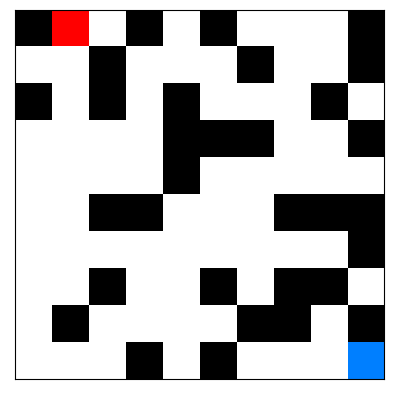

In [156]:
environment, start, reach = generateEnvironment(TEST_WORLD_SIZE)
showGrid(environment, "base_environment")

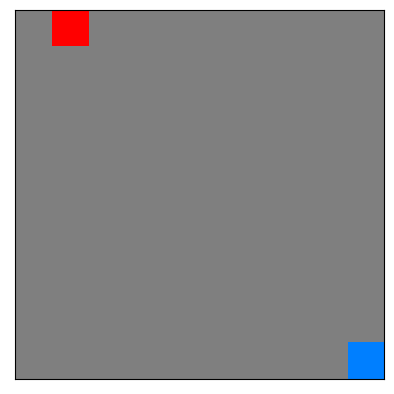

In [157]:
agentKnowledge = initAgentKnowlegde(environment, start, reach)
showGrid(agentKnowledge, "agent_starts_with")

In [158]:
def maxEvaluatedNeighbour(LeafNodes, evaluationFunction, environment):
    neighbourOrder = []
    for i,j in LeafNodes:
        neighbourOrder.append((i,j,evaluationFunction[i,j]))
    return sorted(neighbourOrder, key=itemgetter(2), reverse=True)

In [159]:
def AStar(environment, agentKnowledge, start, reach):
    ## Function g(s) initialization
    gcostFunction = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    ## Functon h(s) initialization
    hueristicFunction  = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    ## Function f(s) 
    evaluationFunction = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    priorityOpenList = MinHeap()
    path = [] 
    pathlength = 0
    ## Structure similar to DFS. 
    openList = []
    closeList = []
    target = []
    newNeighbours = []
    #openList.append(start)
    gcostFunction[start[0],start[1]] = 0
    hueristicFunction[start[0],start[1]] = manhattanDistance(start,reach)
    evaluationFunction[start[0],start[1]] = gcostFunction[start[0],start[1]] + hueristicFunction[start[0],start[1]] 
    #priorityOpenList.put((evaluationFunction[start[0],start[1]],start))
    priorityOpenList.insert((evaluationFunction[start[0],start[1]],start))
    while(priorityOpenList.length()>0):
        current = priorityOpenList.pop()
        closeList.append(current[1])
        pathlength = pathlength + 1
        if current[1] == reach:
            return "CellFound", closeList, hueristicFunction, evaluationFunction
        LeafNodes = list(filter(lambda x: environment[x]==UNBLOCKED or environment[x]==END or environment[x]==START , calculateAllNeighbours(current[1], TEST_WORLD_SIZE)))
        for nx,ny in LeafNodes:
            #print(current[1],(nx,ny))
            if (nx,ny) in closeList:
                continue
            else:
                gcostFunction[nx,ny] = gcostFunction[current[1]] + 1
                hueristicFunction[nx,ny] = manhattanDistance((nx,ny),reach)
                evaluationFunction[nx,ny] = gcostFunction[nx,ny] + hueristicFunction[nx,ny]
                #print((nx,ny),gcostFunction[nx,ny],hueristicFunction[nx,ny],evaluationFunction[nx,ny])
                priorityOpenList.insert((evaluationFunction[nx,ny],(nx,ny)))
                #print(closeList)
                

    return "NotFound", hueristicFunction, evaluationFunction, len(newNeighbours), reach

In [160]:
AStar(environment, agentKnowledge, start, reach)

('NotFound',
 array([[ 0, 17, 16,  0, 14,  0, 12, 11, 10,  0],
        [17, 16,  0, 14, 13, 12,  0, 10,  9,  0],
        [ 0, 15,  0, 13,  0, 11, 10,  9,  0,  0],
        [15, 14, 13, 12,  0,  0,  0,  8,  7,  0],
        [14, 13, 12, 11,  0,  9,  8,  7,  6,  5],
        [13, 12,  0,  0,  9,  8,  7,  0,  0,  0],
        [12, 11, 10,  9,  8,  7,  6,  5,  4,  0],
        [11, 10,  0,  8,  7,  0,  5,  0,  0,  0],
        [10,  0,  8,  7,  6,  5,  0,  0,  0,  0],
        [ 9,  8,  7,  0,  5,  0,  0,  0,  0,  0]]),
 array([[ 0, 17, 17,  0, 25,  0, 29, 27, 27,  0],
        [19, 17,  0, 23, 23, 23,  0, 25, 25,  0],
        [ 0, 17,  0, 21,  0, 23, 23, 23,  0,  0],
        [21, 17, 17, 19,  0,  0,  0, 25, 23,  0],
        [19, 17, 17, 17,  0, 23, 21, 21, 21, 21],
        [19, 17,  0,  0, 23, 21, 19,  0,  0,  0],
        [19, 17, 17, 17, 17, 17, 17, 17, 17,  0],
        [19, 17,  0, 17, 17,  0, 17,  0,  0,  0],
        [19,  0, 21, 17, 17, 17,  0,  0,  0,  0],
        [19, 19, 19,  0, 17,  0,  0